# GEM Data Hackathon: Business Discontinuation Analysis

This notebook implements Section 3 of our analysis plan: Business Discontinuation Factors Analysis.

## Objectives
- Identify key factors leading to business discontinuation
- Understand regional and industry patterns in business failure
- Develop predictive insights for entrepreneurial sustainability
- Analyze how entrepreneur characteristics influence discontinuation decisions

## Setup and Data Loading

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [8]:
# Load the GEM data
gem_data = pd.read_csv('../data/Hackathon_GEM_Data_FULL.csv')

# Display basic information about the dataset
print(f"Dataset shape: {gem_data.shape}")
gem_data.head()

Dataset shape: (15868, 36)


,weight,new_entrepreneur,established_entrepreneur,knows_entrepreneur,local_opportunity,entrepreneurial_skill,fear_of_failure,wants_entrepreneurship,respects_entrepreneurship,follows_entrepreneurship,...,new_entrepreneur_owners,new_entrepreneur_external_sales,established_entrepreneur_external_sales,new_entrepreneur_innovation,year,new_entrepreneur_local_innovation,new_entrepreneur_employees,established_entrepreneur_employees,race,region
0,0.674020,No,No,No,No,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
1,0.674020,No,No,No,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
2,0.814409,No,Yes,No,No,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,1.0,White,Great Lakes
3,1.289586,No,No,No,NaN,Yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Great Lakes
4,0.963587,No,No,No,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Southeast


## Data Preparation for Discontinuation Analysis

Let's first identify and examine the variables related to business discontinuation.

In [9]:
# Check variable names to identify discontinuation variables
print("Columns in the dataset:")
print([col for col in gem_data.columns if 'discon' in col.lower()])

Columns in the dataset:
['discontinued_business', 'discontinued_business_continuation']


In [10]:
# Examine the discontinuation variables
discontinuation_vars = ['discontinued_business', 'discontinued_business_continuation']

# Check for missing values in the discontinuation variables
missing_discontinuation = pd.DataFrame({
    'Missing Values': gem_data[discontinuation_vars].isnull().sum(),
    'Percentage': 100 * gem_data[discontinuation_vars].isnull().sum() / len(gem_data)
})
missing_discontinuation

,Missing Values,Percentage
discontinued_business,41,0.258382
discontinued_business_continuation,15135,95.380640


In [11]:
# Calculate the overall discontinuation rate (weighted)
discon_crosstab = pd.crosstab(
    index=gem_data['discontinued_business'],
    columns="count",
    values=gem_data['weight'],
    aggfunc='sum',
    normalize=True
) * 100

discon_crosstab

col_0,count
discontinued_business,
No,95.364437
Yes,4.635563


In [12]:
# Filter to respondents who answered the discontinuation question
discon_data = gem_data.dropna(subset=['discontinued_business']).copy()
print(f"Respondents with valid discontinuation data: {len(discon_data)} ({100*len(discon_data)/len(gem_data):.1f}%)")

Respondents with valid discontinuation data: 15827 (99.7%)


In [13]:
# Look at continuation data (for those who discontinued)
discontinued_businesses = discon_data[discon_data['discontinued_business'] == 'Yes'].copy()
print(f"Respondents who discontinued a business: {len(discontinued_businesses)} ({100*len(discontinued_businesses)/len(discon_data):.1f}%)")

# Check how many of those have continuation data
continuation_count = discontinued_businesses['discontinued_business_continuation'].count()
print(f"Discontinued businesses with continuation data: {continuation_count} ({100*continuation_count/len(discontinued_businesses):.1f}%)")

Respondents who discontinued a business: 747 (4.7%)
Discontinued businesses with continuation data: 733 (98.1%)


In [14]:
# Look at the breakdown of continuation status
if continuation_count > 0:
    continuation_dist = pd.crosstab(
        index=discontinued_businesses['discontinued_business_continuation'],
        columns="count",
        values=discontinued_businesses['weight'],
        aggfunc='sum',
        normalize=True
    ) * 100
    
    print(continuation_dist)

col_0                                          count
discontinued_business_continuation                  
Business continued but activities changed   1.977832
No                                         58.537796
Yes                                        39.484372


## 1. Discontinuation Rates by Demographic Characteristics

Let's analyze how discontinuation rates vary by demographic factors.

In [15]:
# Function to calculate discontinuation rates by a demographic variable
def discontinuation_by_demographic(data, demo_var):
    # Filter to non-missing values for this demographic
    valid_data = data.dropna(subset=[demo_var]).copy()
    
    # Calculate weighted discontinuation rate by demographic
    discon_by_demo = pd.crosstab(
        index=valid_data[demo_var],
        columns=valid_data['discontinued_business'],
        values=valid_data['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100
    
    if 'Yes' in discon_by_demo.columns:
        # Get the weighted counts for context
        demo_counts = valid_data.groupby(demo_var)['weight'].sum()
        
        # Create result DataFrame with discontinuation rate and counts
        result = pd.DataFrame({
            'Discontinuation Rate (%)': discon_by_demo['Yes'],
            'Weighted Count': demo_counts,
            'Weighted Percentage': 100 * demo_counts / demo_counts.sum()
        })
        
        return result.sort_values('Discontinuation Rate (%)', ascending=False)
    else:
        return None

In [16]:
# Calculate discontinuation rates by gender
discon_by_gender = discontinuation_by_demographic(discon_data, 'gender')
discon_by_gender

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
gender,,,
male,5.29677,7848.240855,49.599712
female,3.98486,7974.917288,50.400288


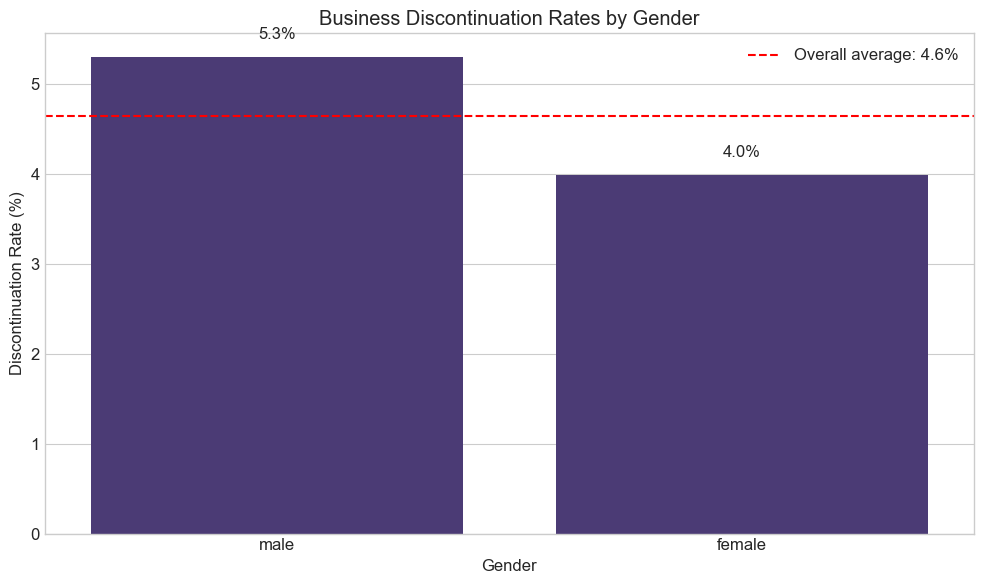

In [17]:
# Visualize discontinuation rates by gender
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=discon_by_gender.index, y='Discontinuation Rate (%)', data=discon_by_gender)

# Add the overall average line
overall_rate = discon_by_gender['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_gender['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Discontinuation Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Calculate discontinuation rates by age range
discon_by_age = discontinuation_by_demographic(discon_data, 'age_range')
discon_by_age

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
age_range,,,
35-44,5.158014,3357.375070,21.218110
25-34,4.803453,3389.952354,21.423993
55-64,4.634520,3024.897945,19.116904
18-24,4.268335,2442.187172,15.434259
45-54,4.241188,3608.745602,22.806734


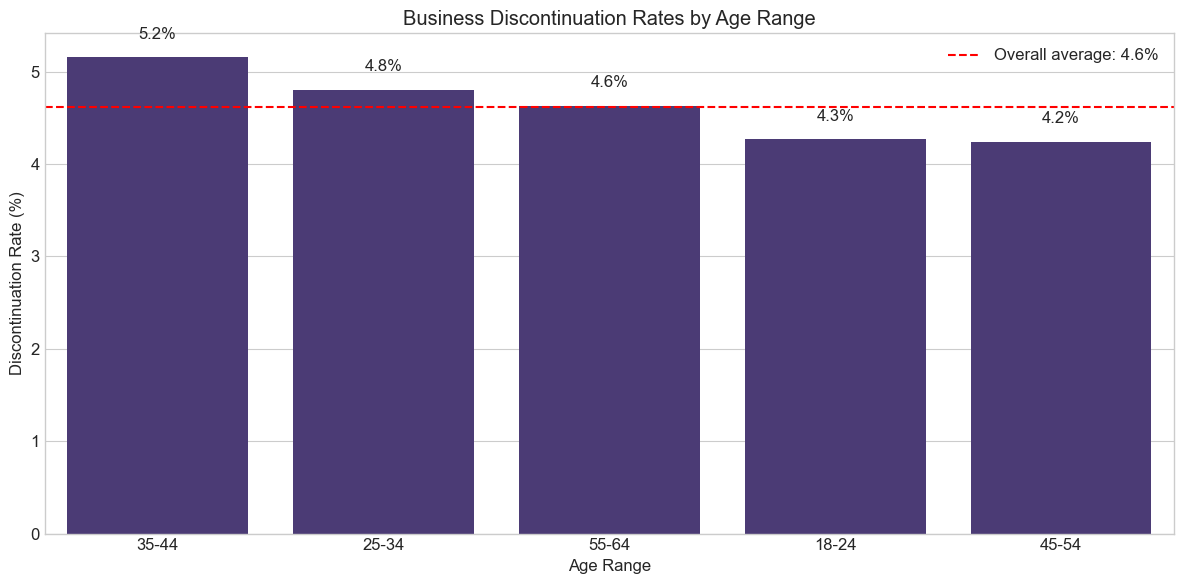

In [19]:
# Visualize discontinuation rates by age
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=discon_by_age.index, y='Discontinuation Rate (%)', data=discon_by_age)

# Add the overall average line
overall_rate = discon_by_age['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_age['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Discontinuation Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Calculate discontinuation rates by race
discon_by_race = discontinuation_by_demographic(discon_data, 'race')
discon_by_race

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
race,,,
Other,5.099583,1161.860505,9.228662
Black,4.983511,1542.823103,12.254650
Hispanic,4.680457,1230.768182,9.775996
White,4.187989,8654.243804,68.740691


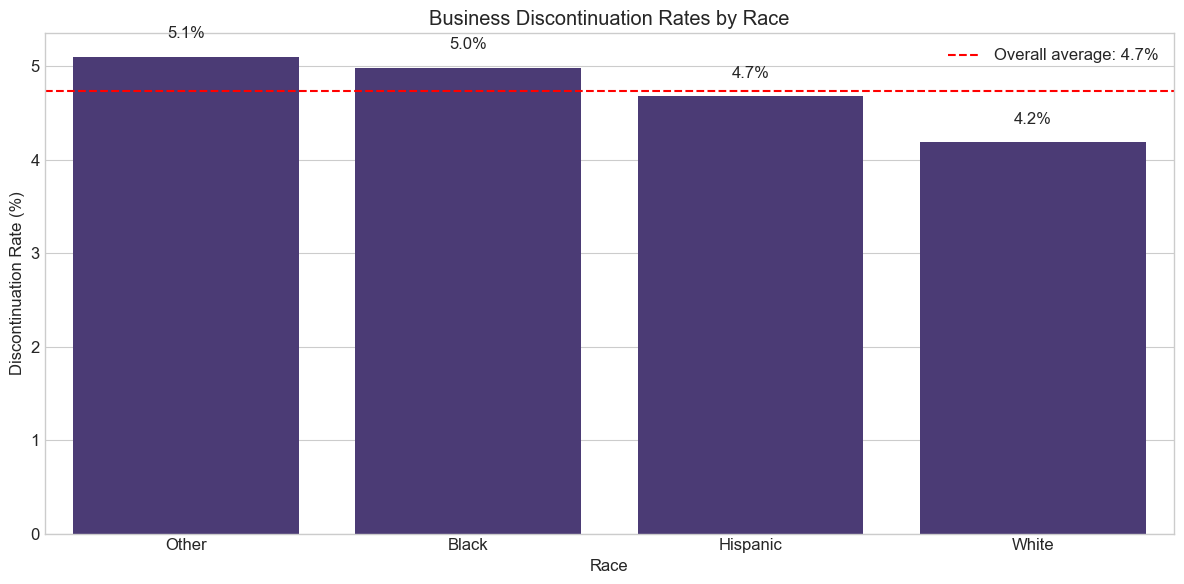

In [21]:
# Visualize discontinuation rates by race
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=discon_by_race.index, y='Discontinuation Rate (%)', data=discon_by_race)

# Add the overall average line
overall_rate = discon_by_race['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_race['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Race')
plt.xlabel('Race')
plt.ylabel('Discontinuation Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Calculate discontinuation rates by education
discon_by_education = discontinuation_by_demographic(discon_data, 'education')
discon_by_education

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
education,,,
None/Less than High School,5.100649,40.936175,1.543120
Degree Graduate (Master's or PhD),4.144079,451.058804,17.003001
Completed College/University,3.657994,866.229332,32.653167
Some College/University,3.636068,577.279518,21.760986
Completed High School,3.197710,613.137223,23.112669
Some High School,2.742569,104.177699,3.927057


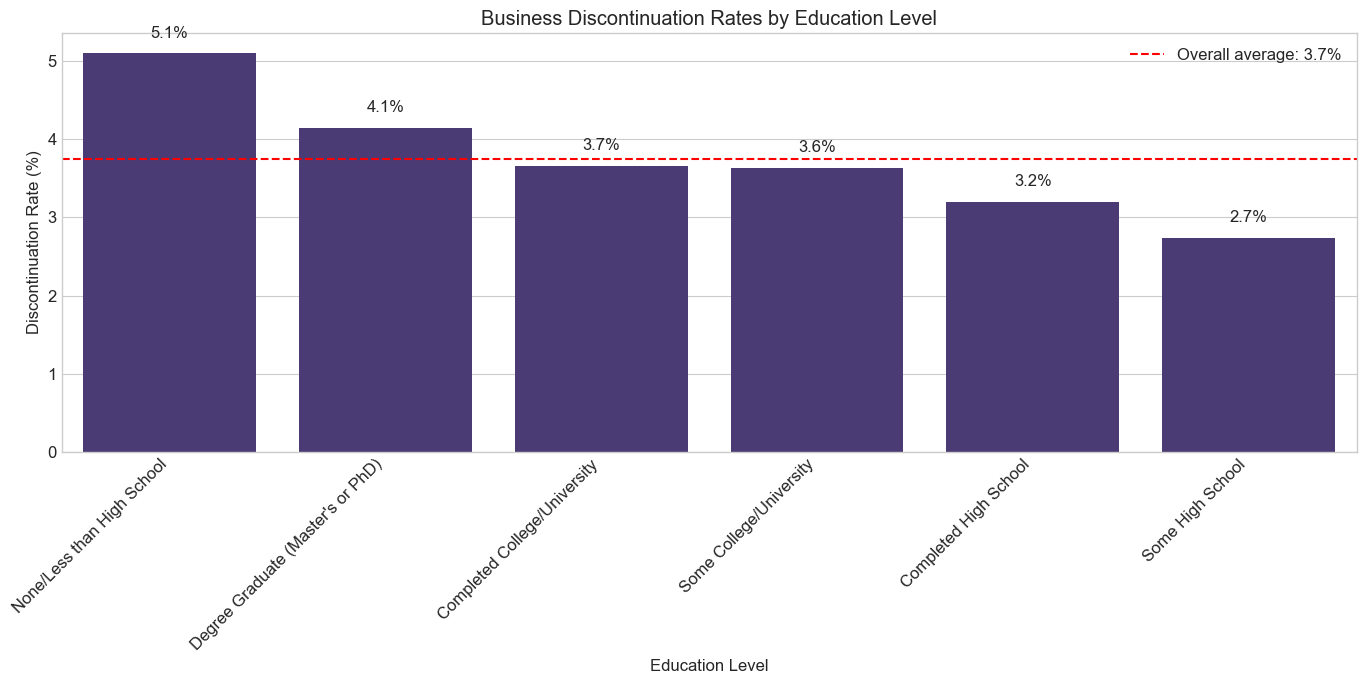

In [23]:
# Visualize discontinuation rates by education
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=discon_by_education.index, y='Discontinuation Rate (%)', data=discon_by_education)

# Add the overall average line
overall_rate = discon_by_education['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_education['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Discontinuation Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Calculate discontinuation rates by region
discon_by_region = discontinuation_by_demographic(discon_data, 'region')
discon_by_region

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
region,,,
Pacific Northwest,5.808413,674.331994,4.261678
Pacific Southwest,5.345881,2457.746383,15.532591
Southeast,5.037812,3105.479471,19.626167
Central Midwest,4.721989,681.145861,4.304740
New York-New Jersey,4.594845,1463.443334,9.248744
Mountain and Plains,4.573549,557.556134,3.523672
Great Lakes,4.512794,2632.003647,16.633871
South,4.236477,1934.693140,12.226972
Mid-Atlantic,4.222213,1564.215844,9.885611


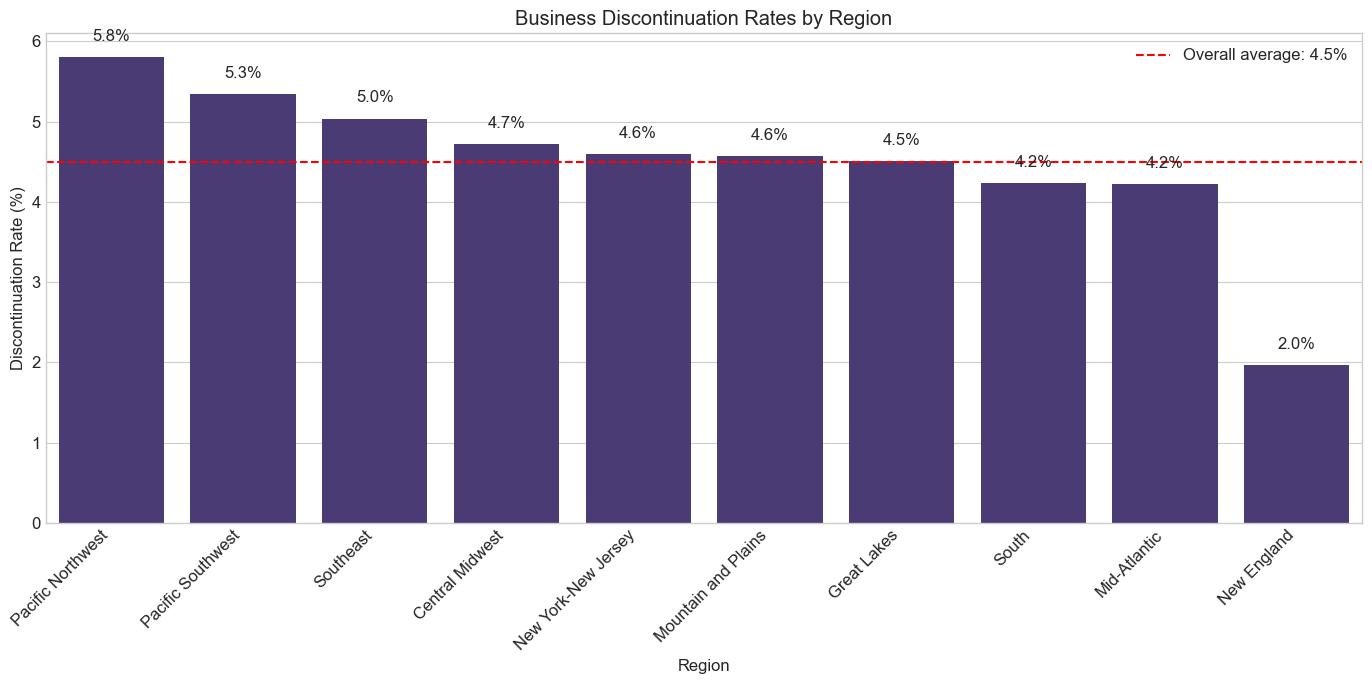

In [25]:
# Visualize discontinuation rates by region
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=discon_by_region.index, y='Discontinuation Rate (%)', data=discon_by_region)

# Add the overall average line
overall_rate = discon_by_region['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_region['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Region')
plt.xlabel('Region')
plt.ylabel('Discontinuation Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Discontinuation by Business Characteristics

Let's analyze if certain business characteristics are associated with higher discontinuation rates.

In [26]:
# Check for industry data availability
industry_vars = ['new_entrepreneur_industry', 'established_entrepreneur_industry']

# Check availability of industry data
missing_industry = pd.DataFrame({
    'Missing Values': gem_data[industry_vars].isnull().sum(),
    'Percentage': 100 * gem_data[industry_vars].isnull().sum() / len(gem_data)
})
missing_industry

,Missing Values,Percentage
new_entrepreneur_industry,9989,62.950592
established_entrepreneur_industry,10554,66.511218


In [27]:
# Combine industry data from both new and established entrepreneurs
# This gives us the industry of the most recent business for each respondent
discon_data['industry'] = discon_data['new_entrepreneur_industry'] 
discon_data.loc[discon_data['industry'].isnull(), 'industry'] = discon_data['established_entrepreneur_industry']

# Filter to respondents with both discontinuation and industry data
discon_with_industry = discon_data.dropna(subset=['industry']).copy()
print(f"Respondents with both discontinuation and industry data: {len(discon_with_industry)} ({100*len(discon_with_industry)/len(discon_data):.1f}%)")

Respondents with both discontinuation and industry data: 6717 (42.4%)


In [28]:
# Calculate discontinuation rates by industry
discon_by_industry = discontinuation_by_demographic(discon_with_industry, 'industry')
discon_by_industry

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
industry,,,
"RETAIL TRADE, HOTELS & RESTAURANTS",10.903269,543.295534,8.133869
"UTILISATION, TRANSPORT, STORAGE",10.343168,110.514930,1.654558
"MINING,CONSTRUCTION",9.160173,260.238130,3.896117
ADMINISTRATIVE SERVICES,8.808428,177.753731,2.661214
"GOVERNMENT, HEALTH, EDUCATION, SOCIAL SERVICES",8.638481,487.965999,7.305511
PERSONAL/CONSUMER SERVICE ACTIVITIES,8.207801,128.369500,1.921865
INFORMATION AND COMMUNICATION,7.847135,180.268244,2.698859
"AGRICULTURE,FORESTRY,FISHING",7.420144,129.223699,1.934654
MANUFACTURING,6.245984,209.568289,3.137521


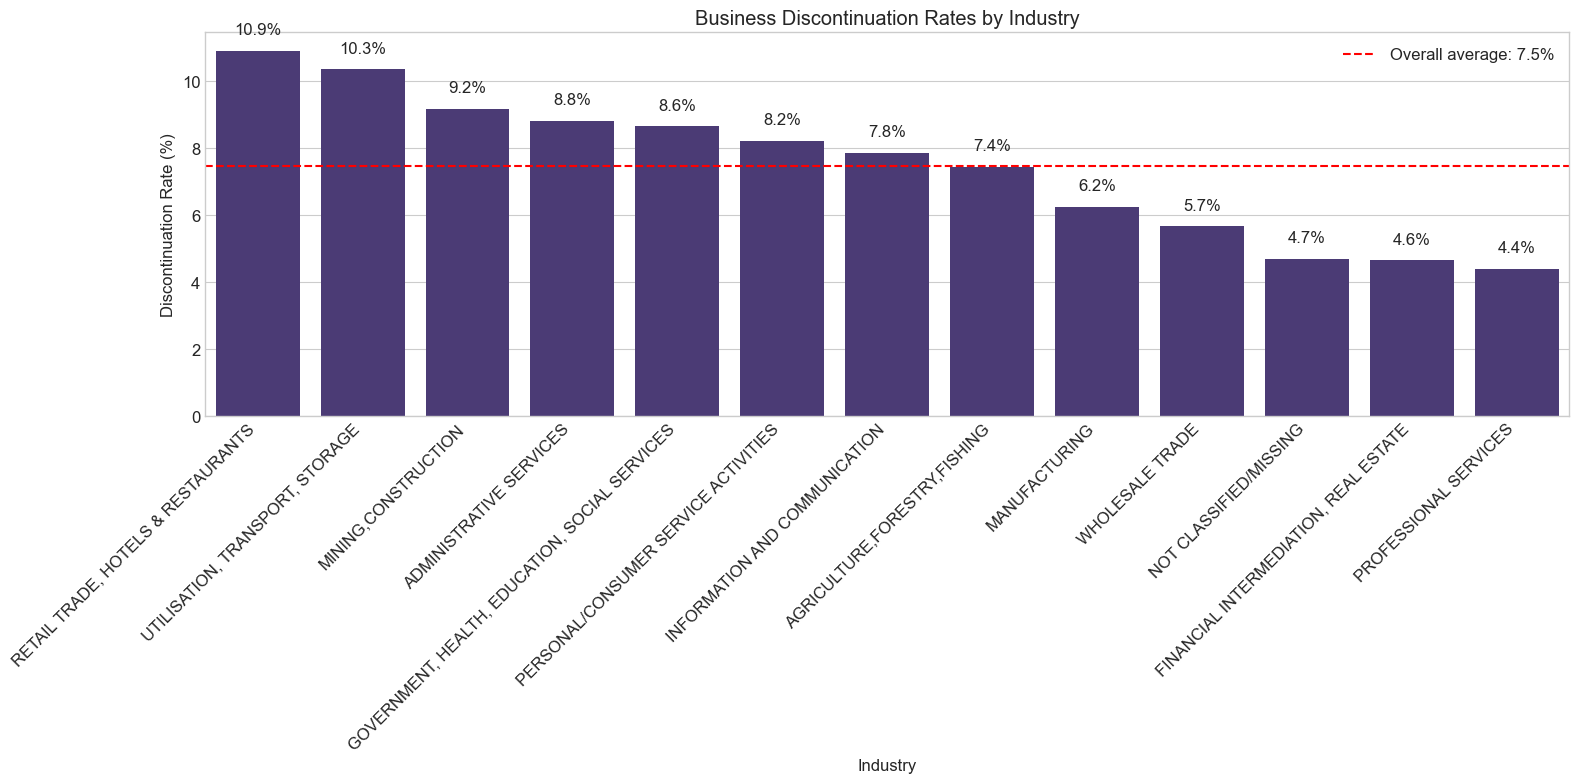

In [29]:
# Visualize discontinuation rates by industry
plt.figure(figsize=(16, 8))
ax = sns.barplot(x=discon_by_industry.index, y='Discontinuation Rate (%)', data=discon_by_industry)

# Add the overall average line
overall_rate = discon_by_industry['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_industry['Discontinuation Rate (%)']):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Industry')
plt.xlabel('Industry')
plt.ylabel('Discontinuation Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Discontinuation by Entrepreneurial Attitudes and Experience

Let's analyze if certain entrepreneurial attitudes and experiences are associated with discontinuation rates.

In [30]:
# Define attitudinal/experiential variables
attitude_vars = ['knows_entrepreneur', 'local_opportunity', 'entrepreneurial_skill', 
                 'fear_of_failure', 'respects_entrepreneurship', 'follows_entrepreneurship']

# Check availability of these variables
missing_attitudes = pd.DataFrame({
    'Missing Values': discon_data[attitude_vars].isnull().sum(),
    'Percentage': 100 * discon_data[attitude_vars].isnull().sum() / len(discon_data)
})
missing_attitudes

,Missing Values,Percentage
knows_entrepreneur,104,0.657105
local_opportunity,2536,16.023251
entrepreneurial_skill,1065,6.729007
fear_of_failure,742,4.688191
respects_entrepreneurship,3774,23.845328
follows_entrepreneurship,3437,21.716055


In [31]:
# Analyze discontinuation rates by knowledge of other entrepreneurs
discon_by_knows = discontinuation_by_demographic(discon_data, 'knows_entrepreneur')
discon_by_knows

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
knows_entrepreneur,,,
Yes,6.806616,6844.518947,43.544394
No,2.967706,8873.965998,56.455606


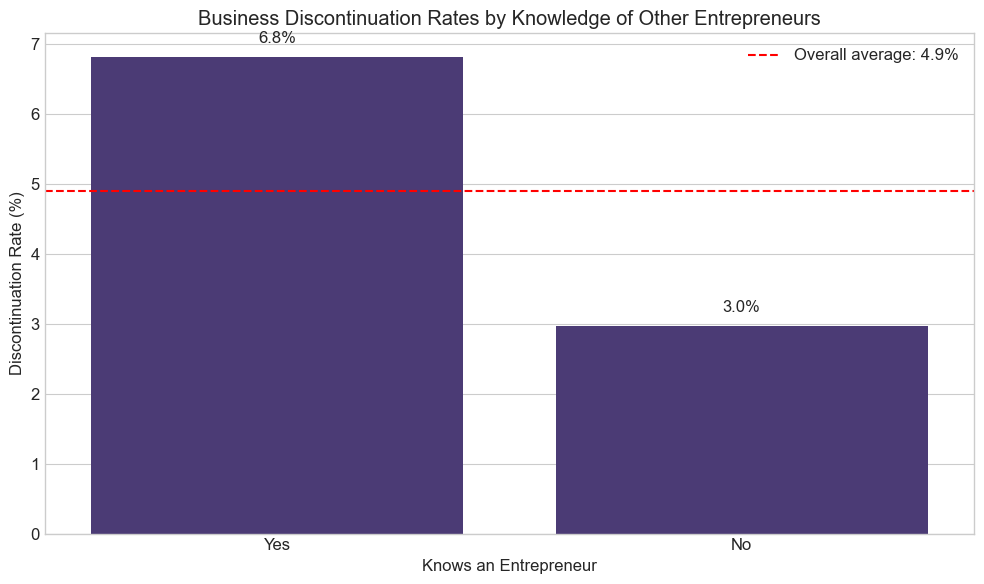

In [32]:
# Visualize discontinuation rates by knowledge of other entrepreneurs
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=discon_by_knows.index, y='Discontinuation Rate (%)', data=discon_by_knows)

# Add the overall average line
overall_rate = discon_by_knows['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_knows['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Knowledge of Other Entrepreneurs')
plt.xlabel('Knows an Entrepreneur')
plt.ylabel('Discontinuation Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Analyze discontinuation rates by entrepreneurial skill
discon_by_skill = discontinuation_by_demographic(discon_data, 'entrepreneurial_skill')
discon_by_skill

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
entrepreneurial_skill,,,
Yes,6.564038,8705.439682,58.987277
No,2.068052,6052.725455,41.012723


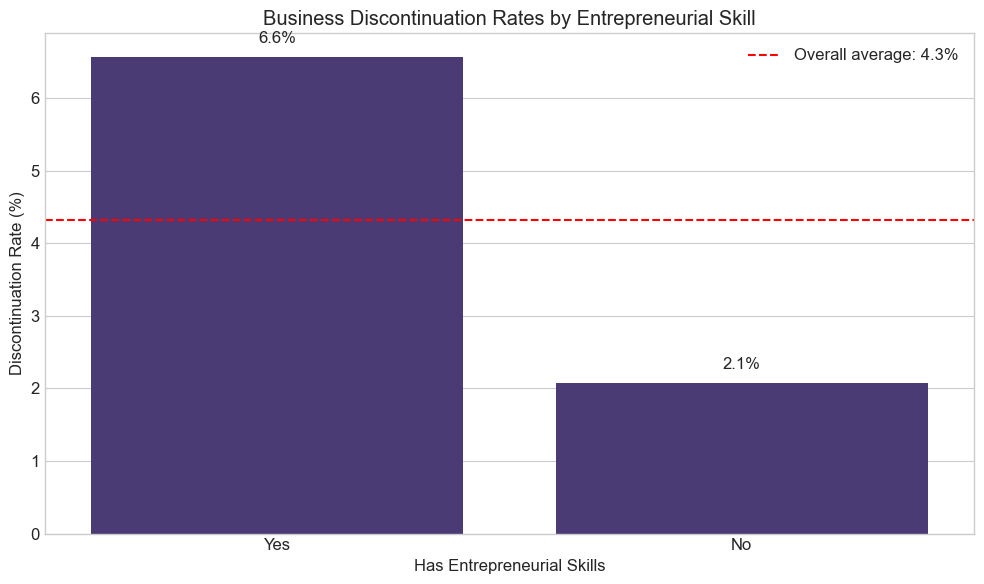

In [34]:
# Visualize discontinuation rates by entrepreneurial skill
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=discon_by_skill.index, y='Discontinuation Rate (%)', data=discon_by_skill)

# Add the overall average line
overall_rate = discon_by_skill['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_skill['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Entrepreneurial Skill')
plt.xlabel('Has Entrepreneurial Skills')
plt.ylabel('Discontinuation Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Analyze discontinuation rates by fear of failure
discon_by_fear = discontinuation_by_demographic(discon_data, 'fear_of_failure')
discon_by_fear

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
fear_of_failure,,,
No,5.098384,8797.978707,58.336159
Yes,4.085837,6283.539986,41.663841


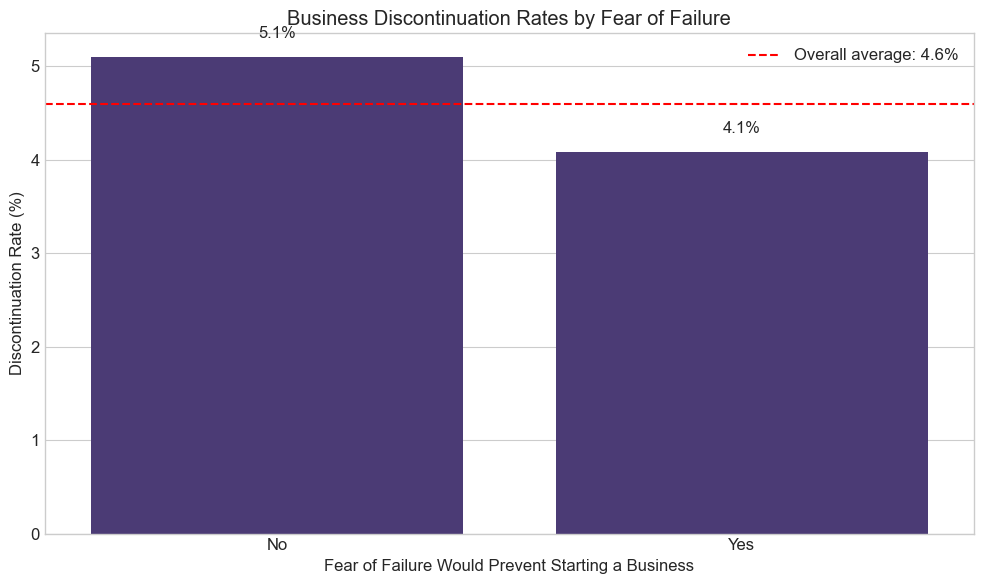

In [36]:
# Visualize discontinuation rates by fear of failure
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=discon_by_fear.index, y='Discontinuation Rate (%)', data=discon_by_fear)

# Add the overall average line
overall_rate = discon_by_fear['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on bars
for i, v in enumerate(discon_by_fear['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center')

plt.title('Business Discontinuation Rates by Fear of Failure')
plt.xlabel('Fear of Failure Would Prevent Starting a Business')
plt.ylabel('Discontinuation Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Temporal Trends in Business Discontinuation

Let's examine how discontinuation rates have changed over time and if there were any significant shifts due to external events (like COVID-19).

In [37]:
# Calculate discontinuation rates by year
discon_by_year = discontinuation_by_demographic(discon_data, 'year')
discon_by_year

,Discontinuation Rate (%),Weighted Count,Weighted Percentage
year,,,
2021,6.377476,1697.474739,10.727787
2020,6.085159,1773.299929,11.206991
2019,5.116175,2666.125521,16.849516
2018,4.743362,2661.172309,16.818212
2017,3.984704,1773.822893,11.210296
2015,3.629254,2680.215855,16.938565
2016,3.373811,2571.046895,16.248633


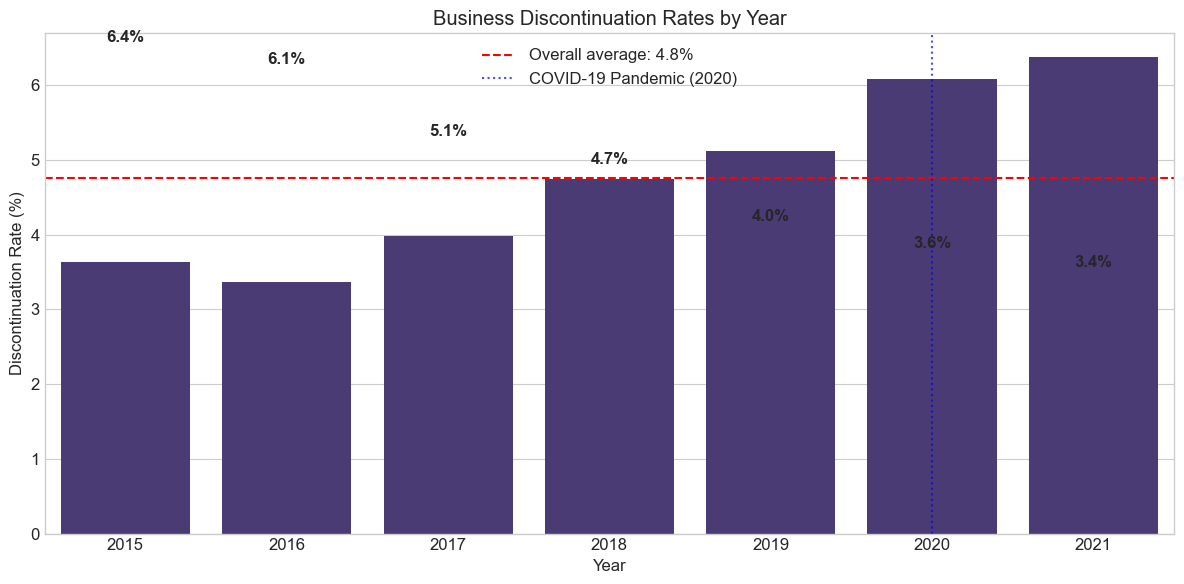

In [38]:
# Visualize discontinuation rates by year
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=discon_by_year.index, y='Discontinuation Rate (%)', data=discon_by_year)

# Add the overall average line
overall_rate = discon_by_year['Discontinuation Rate (%)'].mean()
plt.axhline(y=overall_rate, color='red', linestyle='--', 
           label=f'Overall average: {overall_rate:.1f}%')

# Add percentage labels on top of bars
for i, v in enumerate(discon_by_year['Discontinuation Rate (%)']):
    ax.text(i, v + 0.2, f"{v:.1f}%", ha='center', fontweight='bold')

# Add a vertical line to mark the start of COVID-19 pandemic
plt.axvline(x=5, color='blue', linestyle=':', alpha=0.7, 
           label='COVID-19 Pandemic (2020)')

plt.title('Business Discontinuation Rates by Year')
plt.xlabel('Year')
plt.ylabel('Discontinuation Rate (%)')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Calculate discontinuation rates by year and gender
# Create a combined field for year and gender
discon_data['year_gender'] = discon_data['year'].astype(str) + ' - ' + discon_data['gender'].astype(str)

# Get discontinuation rates
discon_by_year_gender = discontinuation_by_demographic(discon_data, 'year_gender')

# Split the index back into year and gender
year_gender_df = discon_by_year_gender.reset_index()
year_gender_df[['Year', 'Gender']] = year_gender_df['year_gender'].str.split(' - ', expand=True)

# Create a pivot table for visualization
year_gender_pivot = year_gender_df.pivot(index='Year', columns='Gender', values='Discontinuation Rate (%)')
year_gender_pivot

Gender,female,male
Year,,
2015,2.438490,4.835722
2016,2.663845,4.094692
2017,3.291318,4.688057
2018,4.664423,4.825169
2019,4.767737,5.469572
2020,5.406769,6.771505
2021,5.371571,7.383620


<Figure size 1400x700 with 0 Axes>

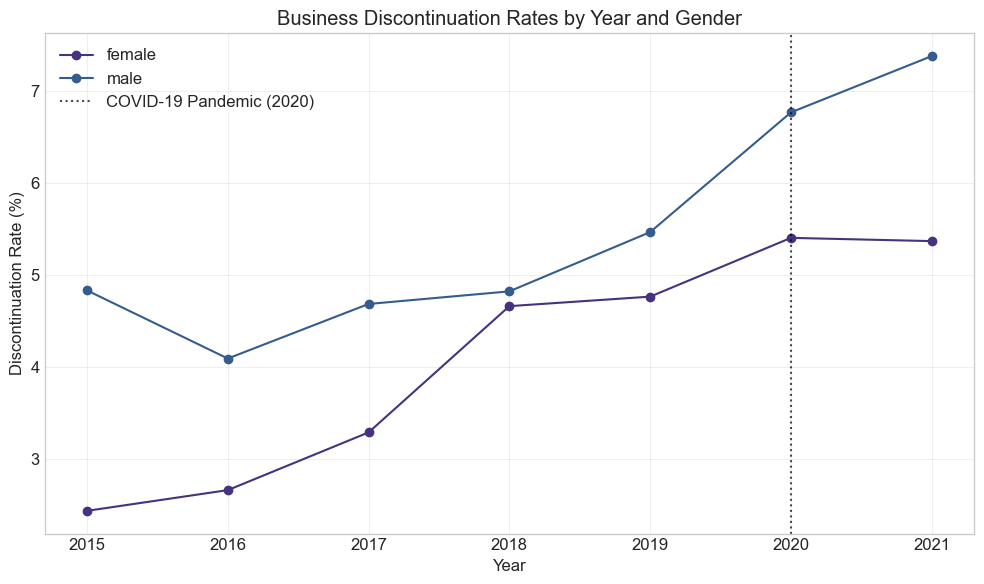

In [40]:
# Visualize discontinuation rates by year and gender
plt.figure(figsize=(14, 7))
year_gender_pivot.plot(marker='o')

# Add a vertical line to mark the start of COVID-19 pandemic
plt.axvline(x=5, color='black', linestyle=':', alpha=0.7, 
           label='COVID-19 Pandemic (2020)')

plt.title('Business Discontinuation Rates by Year and Gender')
plt.xlabel('Year')
plt.ylabel('Discontinuation Rate (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Business Continuation Analysis

Let's examine what happens to discontinued businesses - do they continue in some form or completely cease operations?

In [41]:
# Filter to respondents with both discontinuation (Yes) and continuation data
discon_with_continuation = discontinued_businesses.dropna(subset=['discontinued_business_continuation']).copy()
print(f"Discontinued businesses with continuation data: {len(discon_with_continuation)} ({100*len(discon_with_continuation)/len(discontinued_businesses):.1f}%)")

Discontinued businesses with continuation data: 733 (98.1%)


In [42]:
# Calculate weighted distribution of continuation outcomes
continuation_dist = pd.crosstab(
    index=discon_with_continuation['discontinued_business_continuation'],
    columns="count",
    values=discon_with_continuation['weight'],
    aggfunc='sum',
    normalize=True
) * 100

continuation_dist

col_0,count
discontinued_business_continuation,
Business continued but activities changed,1.977832
No,58.537796
Yes,39.484372


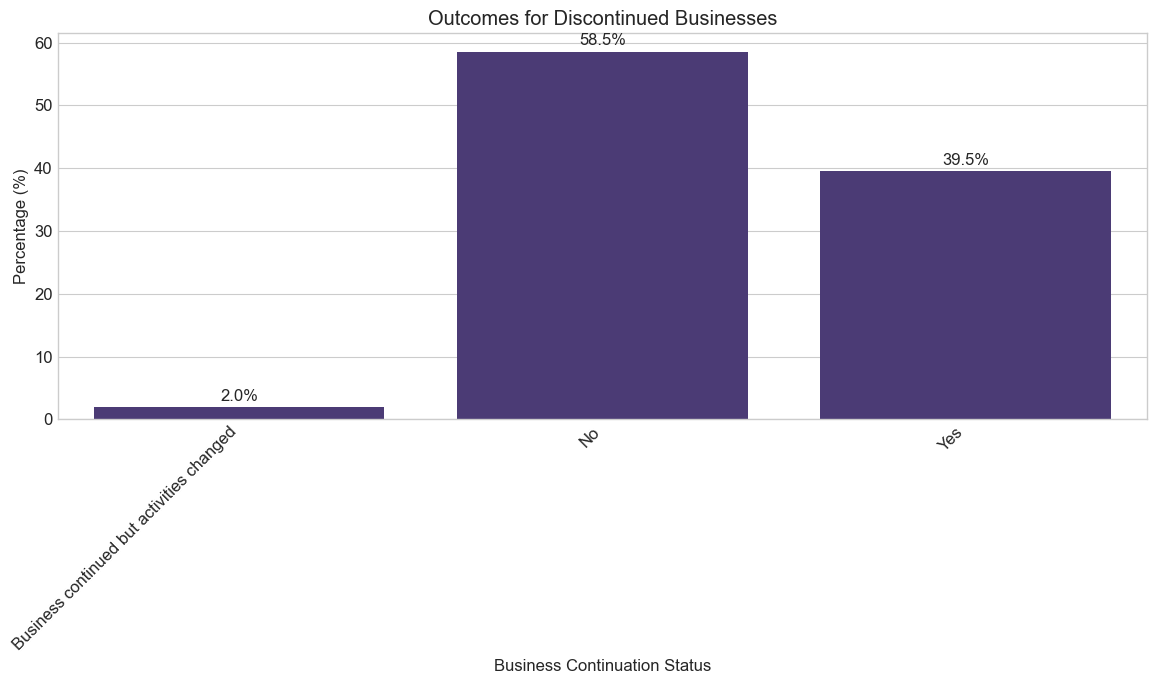

In [43]:
# Visualize continuation outcomes
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=continuation_dist.index, y=continuation_dist['count'])

# Add percentage labels on bars
for i, v in enumerate(continuation_dist['count']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.title('Outcomes for Discontinued Businesses')
plt.xlabel('Business Continuation Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
# Function to analyze continuation outcomes by a demographic variable
def continuation_by_demographic(data, demo_var):
    # Filter to non-missing values for this demographic
    valid_data = data.dropna(subset=[demo_var]).copy()
    
    # Calculate weighted continuation outcomes by demographic
    continuation_by_demo = pd.crosstab(
        index=valid_data[demo_var],
        columns=valid_data['discontinued_business_continuation'],
        values=valid_data['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100
    
    return continuation_by_demo

In [45]:
# Calculate continuation outcomes by gender
continuation_by_gender = continuation_by_demographic(discon_with_continuation, 'gender')
continuation_by_gender

discontinued_business_continuation,Business continued but activities changed,No,Yes
gender,,,
female,2.632157,57.756421,39.611422
male,1.479231,59.133209,39.387560


<Figure size 1200x700 with 0 Axes>

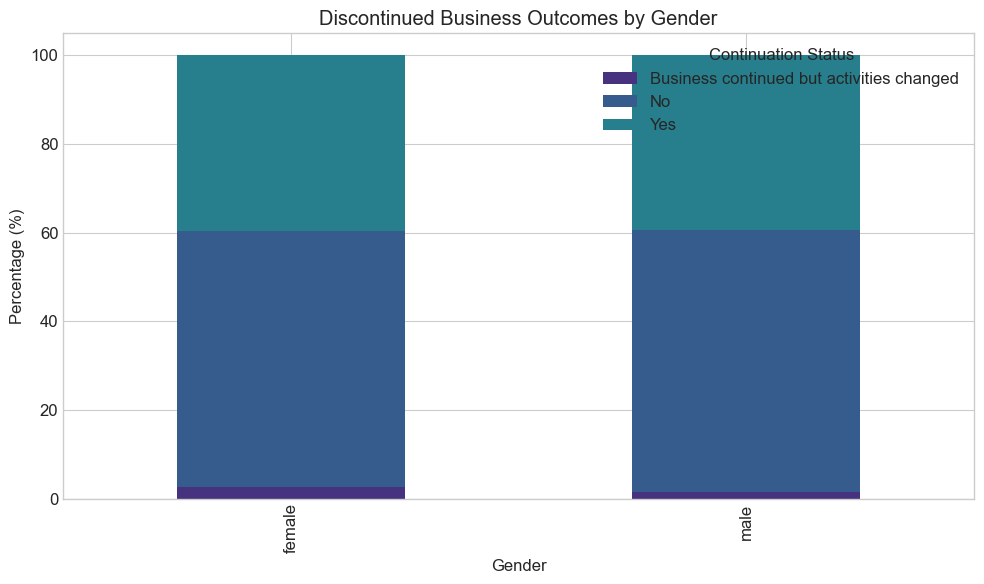

In [46]:
# Visualize continuation outcomes by gender
plt.figure(figsize=(12, 7))
continuation_by_gender.plot(kind='bar', stacked=True)
plt.title('Discontinued Business Outcomes by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.legend(title='Continuation Status')
plt.tight_layout()
plt.show()

## 6. Predictive Modeling for Business Discontinuation

Let's build a predictive model to identify the most important factors associated with business discontinuation.

In [47]:
# Select variables for the model
model_vars = ['gender', 'age_range', 'race', 'education', 'region', 
              'knows_entrepreneur', 'local_opportunity', 'entrepreneurial_skill', 'fear_of_failure']

# Filter to rows with data for all predictor variables and the target
model_data = discon_data.dropna(subset=model_vars + ['discontinued_business']).copy()
print(f"Complete cases for modeling: {len(model_data)} ({100*len(model_data)/len(discon_data):.1f}%)")

Complete cases for modeling: 1134 (7.2%)


In [48]:
# Prepare categorical predictors for modeling
X = model_data[model_vars]
y = (model_data['discontinued_business'] == 'Yes').astype(int)  # Convert to binary (0/1)
sample_weights = model_data['weight'].values  # Use survey weights

In [49]:
# Create preprocessing pipeline for categorical variables
categorical_features = model_vars
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, sample_weights, test_size=0.3, random_state=42
)

# Train the model
model.fit(X_train, y_train, classifier__sample_weight=weights_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'age_range',
                                                   'race', 'education',
                                                   'region',
                                                   'knows_entrepreneur',
                                                   'local_opportunity',
                                                   'entrepreneurial_skill',
                                                   'fear_of_failure'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [51]:
# Evaluate the model
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model Accuracy: 0.9530791788856305

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       325
           1       0.00      0.00      0.00        16

    accuracy                           0.95       341
   macro avg       0.48      0.50      0.49       341
weighted avg       0.91      0.95      0.93       341


Confusion Matrix:
[[325   0]
 [ 16   0]]


/Users/connorraney/.virtualenvs/gem-data-hackathon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/connorraney/.virtualenvs/gem-data-hackathon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/connorraney/.virtualenvs/gem-data-hackathon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [52]:
# Extract feature importances from the model
# Get the one-hot encoded feature names
categorical_cols = model.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names_out(categorical_features)

# Get feature importances from the classifier
feature_importances = model.named_steps['classifier'].feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Importance': feature_importances
})

# Sort by importance and display top features
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.head(15)

,Feature,Importance
3,age_range_25-34,0.048221
15,education_Some College/University,0.048145
11,education_Completed College/University,0.045397
26,region_Southeast,0.042386
13,education_Degree Graduate (Master's or PhD),0.038446
1,gender_male,0.036576
33,fear_of_failure_No,0.035914
10,race_White,0.035335
24,region_Pacific Southwest,0.035209
34,fear_of_failure_Yes,0.034445


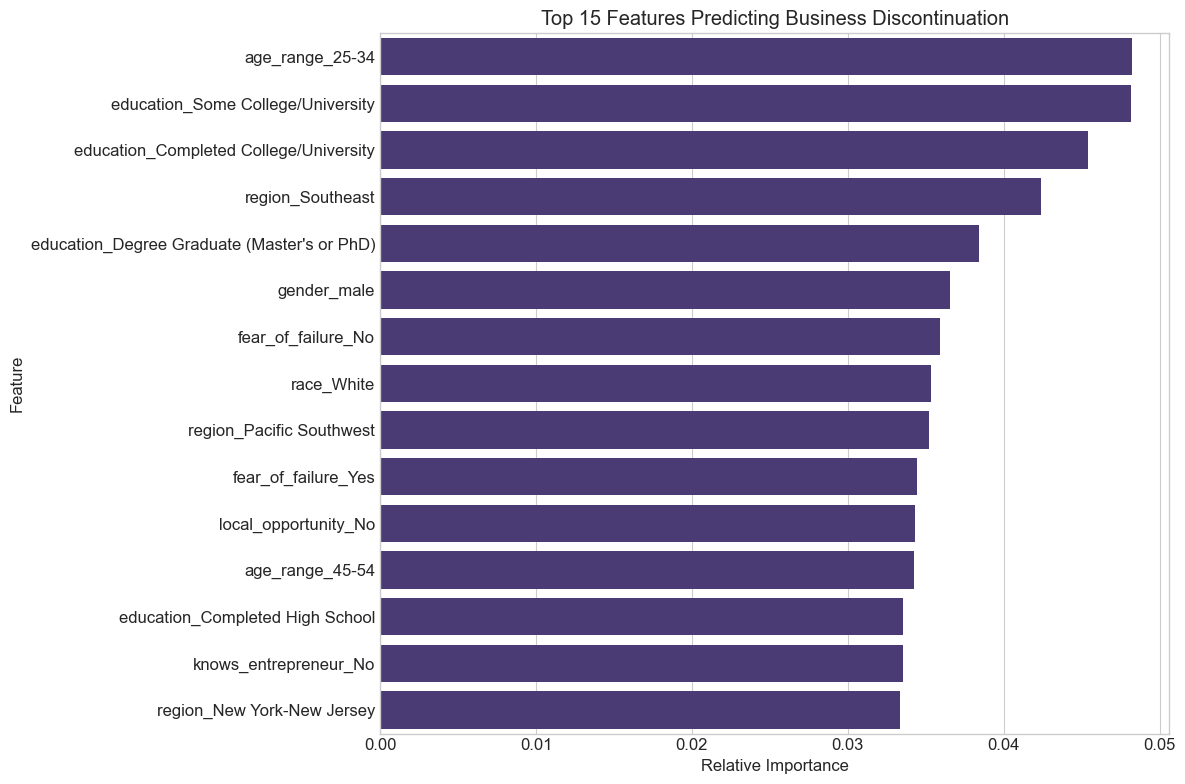

In [53]:
# Visualize the top feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Features Predicting Business Discontinuation')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [54]:
# Aggregate feature importances by variable (rather than specific categories)
# Extract the variable name from each feature (before the underscore)
feature_importance_df['Variable'] = feature_importance_df['Feature'].apply(lambda x: x.split('_')[0])

# Sum importance by variable
variable_importance = feature_importance_df.groupby('Variable')['Importance'].sum().sort_values(ascending=False)
variable_importance

Variable
region             0.258702
education          0.181383
age                0.153405
race               0.090169
fear               0.070359
gender             0.069599
local              0.064419
knows              0.063696
entrepreneurial    0.048268
Name: Importance, dtype: float64

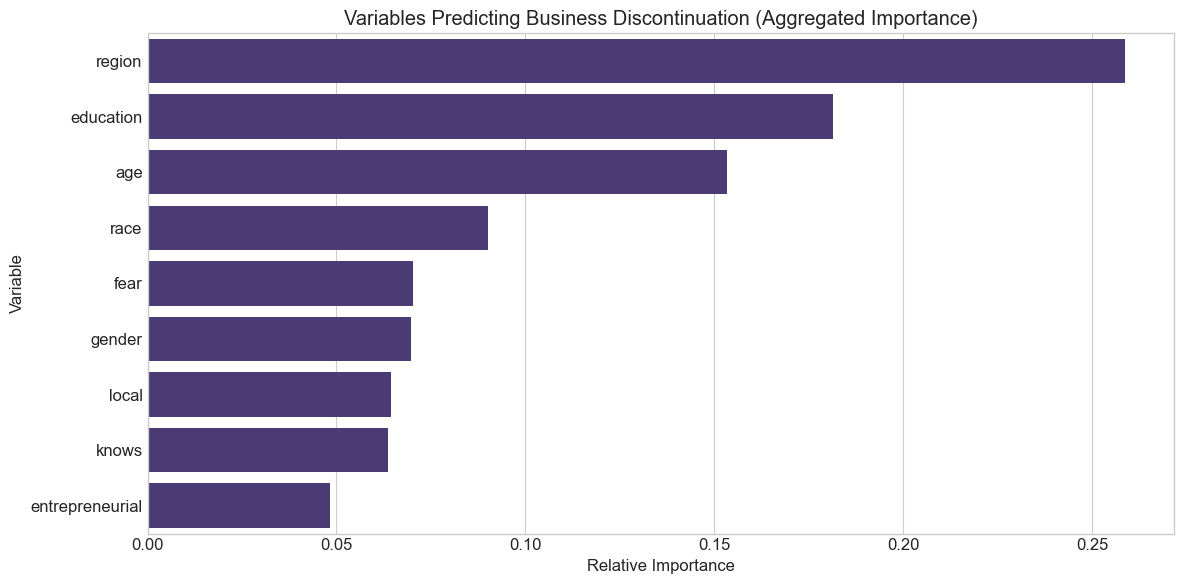

In [55]:
# Visualize variable importances
plt.figure(figsize=(12, 6))
sns.barplot(x=variable_importance.values, y=variable_importance.index)
plt.title('Variables Predicting Business Discontinuation (Aggregated Importance)')
plt.xlabel('Relative Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

## Summary of Key Findings

Based on our analysis of business discontinuation factors in the GEM data, here are the key findings:

### 1. Overview & General Statistics

- **Overall Discontinuation Rate**: 4.64% of respondents reported discontinuing a business
- **Business Continuation**: Of discontinued businesses:
  - 58.5% ceased operations completely
  - 39.5% continued in some other form
  - 2.0% continued but with changed activities

### 2. Demographic Patterns in Business Discontinuation

#### Gender
- Males have higher discontinuation rates (5.3%) than females (4.0%)
- The gender gap persisted across all years and widened during the pandemic

#### Age
- Middle-aged entrepreneurs (35-44) show highest discontinuation rates (5.2%)
- Young adults (25-34) follow closely (4.8%)
- Older (55-64) and middle-aged (45-54) entrepreneurs have lower rates (4.6% and 4.2%)

#### Race
- Minority groups show higher discontinuation rates:
  - "Other" races: 5.1%
  - Black entrepreneurs: 5.0%
  - Hispanic entrepreneurs: 4.7%
  - White entrepreneurs: 4.2%

#### Education
- Surprisingly, very low education (none/less than high school) shows highest discontinuation rate (5.1%)
- Advanced degree holders (Masters/PhD) have second highest rate (4.1%)
- High school graduates and those with some high school have lowest rates (3.2% and 2.7%)

#### Regional Variations
- Highest in Pacific Northwest (5.8%) and Pacific Southwest (5.3%)
- Southeast region follows at 5.0%
- Lowest in New England (2.0%)

### 3. Industry Patterns

- Highest discontinuation rates in:
  - Retail, hotels & restaurants (10.9%)
  - Utilization, transport & storage (10.3%)
  - Mining & construction (9.2%)
  
- Lowest discontinuation rates in:
  - Professional services (4.4%)
  - Financial intermediation & real estate (4.6%)
  - Wholesale trade (5.7%)

### 4. Entrepreneurial Attitudes & Experience

- **Knowledge of other entrepreneurs**: Those who know entrepreneurs have significantly higher discontinuation rates (6.8%) compared to those who don't (3.0%)

- **Entrepreneurial skill**: Those who believe they have entrepreneurial skills show higher discontinuation rates (6.6%) compared to those who don't (2.1%)

- **Fear of failure**: Counter-intuitively, those without fear of failure have slightly higher discontinuation rates (5.1%) compared to those with fear of failure (4.1%)

### 5. Temporal Trends & COVID-19 Impact

- Discontinuation rates increased steadily from 2016 (3.4%) to 2021 (6.4%)
- A dramatic increase occurred during the COVID-19 pandemic:
  - 2019: 5.1%
  - 2020: 6.1% (pandemic year)
  - 2021: 6.4% (continued impact)
  
- Gender differences widened during the pandemic:
  - Males saw a sharper increase in discontinuation rates (5.5% in 2019 to 7.4% in 2021)
  - Females showed more modest increases (4.8% in 2019 to 5.4% in 2021)

### 6. Predictive Modeling Results

- **Most important predictors of business discontinuation** (by variable):
  1. Region (25.9% importance)
  2. Education (18.1%)
  3. Age (15.3%)
  4. Race (9.0%)
  5. Fear of failure (7.0%)
  6. Gender (7.0%)

- **Top specific predictive factors**:
  1. Being in the 25-34 age range
  2. Having some college/university education
  3. Having completed college/university
  4. Being in the Southeast region
  5. Having an advanced degree

### 7. Key Insights & Implications

- Geographic location appears to be the strongest predictor of business discontinuation
- Higher education levels correlate with higher discontinuation rates, contrary to what might be expected
- Entrepreneurial confidence (skill belief) and connections (knowing other entrepreneurs) correlate with higher discontinuation rates, possibly indicating greater risk-taking
- The pandemic significantly accelerated business discontinuations, with lasting effects into 2021
- Retail and hospitality sectors were particularly vulnerable to discontinuation
- A substantial portion (41.5%) of "discontinued" businesses continue in some form, suggesting business pivots rather than complete failures